In [ ]:
import networkx as nx
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("ppi_edges_filtered.txt", sep=',', index_col=0)

In [171]:
G = nx.from_pandas_dataframe(df, source="source", target="target", edge_attr="weight")

expressions = pd.read_csv("DREAM7_DrugSensitivity1_GeneExpression.txt", sep="\t", index_col=0)

In [172]:
expressions = expressions.T
expressions.loc[:, :] = StandardScaler().fit_transform(expressions)
expressions = expressions.T

In [173]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Mucking around data...

In [41]:
lessthan_mask = expressions < -3
morethan_mask = expressions > 3

(array([ 13213.,   4817.,      0.,    581.,     21.]),
 array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ]),
 <a list of 5 Patch objects>)

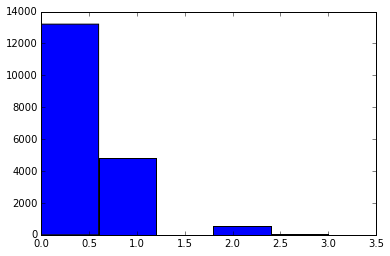

In [42]:
plt.hist((lessthan_mask | morethan_mask).sum(axis=1), bins=5)

In [8]:
np.percentile(expressions.ix[:, 0], 33)

-0.47951339849385477

## Going to use the CDF of the normal dist

Suppose we fix a cell line.

Given a weight in the graph, $w_{ij}$, where $i$ is the source and $j$ is the target, we assign
$$w_{ij} \leftarrow w_{ij} * 2 * \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x exp(\frac{1}{2} x^2)dx$$
This should be recognized as double the CDF of the normal distribution

In [174]:
from scipy.stats import norm
rv = norm()
gene_mappings = pd.read_csv("genes_filtered.txt", index_col=0)
gene_mappings.set_index('id', inplace=True)

In [200]:
def integrate_expressions(G, cellline):
    output = G.copy()
    exprs = expressions[cellline]
    for node in output.nodes_iter():
        gene = gene_mappings.loc[int(node)]
        gene_expression = exprs.loc[gene][0]
        
        # There are no Nan gene expressions
#        if gene_expression == np.nan:
#            continue  # Ignore the nan
            
        # Now we adjust the weights of each of the neighbors by
        # multiplying it by the 2*CDF(expression)
        neighbors = output[node]
        for neighbor in neighbors:
            weight = output[node][neighbor]["weight"]
            output[node][neighbor]["weight"] = 2 * rv.cdf(gene_expression)
    return output


In [ ]:
graph = integrate_expressions(G, "184B5")

In [190]:
gene_mappings.loc[1]

Gene    TNMD
Name: 1, dtype: object